# CITS4403 Project Notebook — Feral Cats vs Prey ABM

**Date:** 2025-10-04  

**Authors:** *Jiajin Kong 25042399*  *Jonas Liu 24198573*

**Repo:** *https://github.com/Oliverkkkk/Feral_Cats_and_Small_Mammals.git*

## 1. Reproducibility & Environment

- Set a global random seed for Python/NumPy (and Torch if present).  
- Capture package versions to enable reproduction.  
- If running in a fresh environment, use `requirements.txt`.

In [1]:
# Optional: one-time install if running in a fresh environment
# !pip install -r ../requirements.txt

import os, sys, random, importlib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import HTML, display

# Make project root importable and ensure 'src' is a package
PROJ_ROOT = os.path.abspath("..") if os.path.isdir("..") else os.getcwd()
if PROJ_ROOT not in sys.path:
    sys.path.insert(0, PROJ_ROOT)

SEED = 4403
random.seed(SEED)
np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass

def _ver(modname):
    try:
        m = importlib.import_module(modname)
        return getattr(m, "__version__", "n/a")
    except Exception:
        return "not installed"
    
# Import the project modules from src/
try:
    from src.model import FeralCatModel, count_cats, count_prey
    from src.visual2d import animate_grid
    print("Successfully imported project modules from src/")
except Exception as e:
    print("Error importing project modules from src/:", e)
    sys.exit(1)


print("Python:", sys.version.split()[0])
print("numpy:", _ver("numpy"))
print("matplotlib:", _ver("matplotlib"))
print("pandas:", _ver("pandas"))
print("mesa:", _ver("mesa"))
print("torch:", _ver("torch"))

e:\Working\Abroad\UWA\Course\CITS4403 Computational Modelling\Project\Feral_Cats_and_Small_Mammals\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported project modules from src/
Python: 3.12.3
numpy: 2.3.3
matplotlib: 3.10.6
pandas: 2.3.2
mesa: 3.3.0
torch: not installed


## 2. Model Overview

We use a grid-based ABM with **cats** (predators) and **prey** (small mammals). The environment supports **vegetation** (0–4) and an optional **river** mask (blocked cells). Key ideas:

- Prey move locally and prefer higher vegetation; females may reproduce when vegetation is sufficient and a male is nearby, after a cooldown.  
- Cats move locally, biasing recent prey trails; they attempt predation once per sub-step and gain energy on success; energy depletes over time leading to death.  
- A **cat scent** field (Chebyshev radius ≤ 2) is refreshed each step and can trigger prey fleeing.

### Model Parameters

We centralise key parameters for clarity and reuse in experiments.

| Parameter | Type (Default) | What it controls | Typical range / notes |
|---|---|---|---|
| `width`, `height` | `int` (25, 25) | Size of the 2-D grid in cells (columns × rows). Total habitat size is `width × height`. | Larger grids dilute encounters; smaller grids increase contact rates. Keep vegetation/river maps the same shape. |
| `n_cats` | `int` (8) | Initial number of predator agents (cats). | Higher values increase early predation pressure and energy turnover. |
| `n_prey` | `int` (80) | Initial number of prey agents. | Sets starting prey density; affects time to equilibrium/extinction. |
| `predation_base` | `float` (0.20) | Baseline per-encounter predation probability, independent of vegetation. | Used in the predation formula below. Should be in [0,1]. |
| `predation_coef` | `float` (0.10) | Increment added to predation probability per unit of vegetation at the cell. | Predation probability is modeled as **p =** `predation_base` + `predation_coef` × vegetation. Clip to [0,1]. If vegetation ∈ {0,…,4}, choose values so the upper bound stays < 1. |
| `prey_flee_prob` | `float` (0.40) | Probability that a prey executes **flee** behavior when cat scent is detected. | Higher values reduce successful predation short-term but may increase movement costs/congestion elsewhere. |
| `seed` | `int` (`SEED`) | Random number generator seed for reproducibility. | Fix this in reported experiments; vary it across replications to estimate variability. |
| `vegetation` | `np.ndarray` or `None` (`None`) | Optional integer grid with vegetation levels per cell (e.g., 0–4). Influences habitat quality and the predation formula above. | Shape must be `(height, width)`. If `None`, a default map is generated/assumed. |
| `river` | `np.ndarray` or `None` (`None`) | Optional boolean/0–1 mask of blocked cells (river/obstacles) that agents cannot occupy. | Shape must be `(height, width)`. If `None`, no barrier is applied. |

**Predation rule.** Let `veg(i,j)` be the vegetation level at cell (i,j). The instantaneous predation probability used in the model is:

$$
p_{\text{pred}}(i,j)
= \text{predation\_base}
+ \text{predation\_coef}\times \text{veg}(i,j)
$$

clipped to \[0,1\]. Thus, richer vegetation increases the chance that a cat successfully hunts at that location.


In [2]:
from dataclasses import dataclass

@dataclass
class Params:
    width: int = 25
    height: int = 25
    n_cats: int = 8
    n_prey: int = 80
    predation_base: float = 0.20
    predation_coef: float = 0.10
    prey_flee_prob: float = 0.40
    seed: int = SEED
    vegetation: np.ndarray | None = None
    river: np.ndarray | None = None

P = Params()
P

Params(width=25, height=25, n_cats=8, n_prey=80, predation_base=0.2, predation_coef=0.1, prey_flee_prob=0.4, seed=4403, vegetation=None, river=None)

## 3. Running a Single Simulation

This part  is going to run one model **until stop** (prey extinct) or for a fixed maximum number of steps, and return **tidy** per-step metrics using Mesa's `DataCollector`.

In [24]:
def run_once(params: Params, max_steps=300, seed_offset=0):
    m = FeralCatModel(
        width=params.width, height=params.height,
        n_cats=params.n_cats, n_prey=params.n_prey,
        predation_base=params.predation_base, predation_coef=params.predation_coef,
        prey_flee_prob=params.prey_flee_prob, seed=(params.seed + seed_offset),
        vegetation=params.vegetation, river=params.river
    )
    steps = 0
    while m.running and steps < max_steps:
        m.step()
        steps += 1
    df = m.datacollector.get_model_vars_dataframe().reset_index().rename(columns={"index":"step"})
    df["stopped"] = not m.running
    df["total_steps"] = steps
    return df, m

# quick smoke test
df0, m0 = run_once(P, max_steps=50)
df0.head(10)

,step,Cats,Prey,predation_events_this_step,predation_events_total,stopped,total_steps
0,0,8,79,1,1,False,50
1,1,8,78,2,3,False,50
2,2,8,76,5,8,False,50
3,3,8,72,4,12,False,50
4,4,8,71,2,14,False,50
5,5,8,71,1,15,False,50
6,6,8,69,2,17,False,50
7,7,8,68,3,20,False,50
8,8,8,65,3,23,False,50
9,9,8,64,1,24,False,50


### Visual Check: Static Time Series

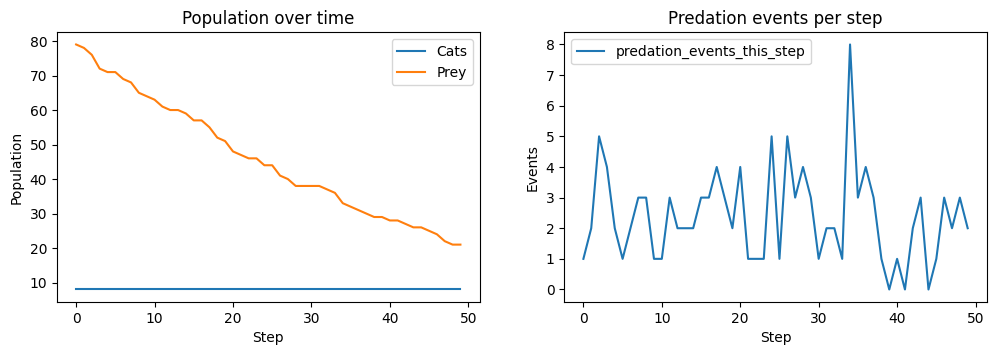

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3.5))
ax1.plot(df0["step"], df0["Cats"], label="Cats")
ax1.plot(df0["step"], df0["Prey"], label="Prey")
ax1.set_xlabel("Step"); ax1.set_ylabel("Population"); ax1.set_title("Population over time")
ax1.legend()

ax2.plot(df0["step"], df0["predation_events_this_step"], label="predation_events_this_step")
ax2.set_title("Predation events per step"); ax2.set_xlabel("Step"); ax2.set_ylabel("Events")
ax2.legend()

plt.show()

### 2D Animation
Set `steps` and toggle the **scent** overlay interactively by changing `SCENT[0]`.

In [26]:
# Note: animations can be heavy; keep steps small when previewing.
SCENT = [True]  # toggle in-place inside this list
fig, anim = animate_grid(
    FeralCatModel(
        width=P.width, height=P.height, n_cats=P.n_cats, n_prey=P.n_prey,
        predation_base=P.predation_base, predation_coef=P.predation_coef,
        prey_flee_prob=P.prey_flee_prob, seed=P.seed
    ),
    steps=60, interval_ms=120, figsize=(5,5),
    scent_enabled=lambda: SCENT[0]
)

# To display in Jupyter as JS:
html = anim.to_jshtml()   # generate HTML first
import matplotlib.pyplot as plt
plt.close(fig)            # close the figure to prevent auto-display in Jupyter
from IPython.display import HTML
HTML(html)

## 4. Experiments


We evaluate 6 scenarios under the default randomly generated vegetation to illustrate how contact rate, predation intensity, anti-predator behaviour, spatial scale, and near-threshold sensitivity shape the system’s dynamics. We report extinction rate, average time-to-extinction (TTE), and final populations. 

Moreover, we repeated experiments with 10 random seeds for each scenario to reduce randomness, estimate fluctuations in results, and obtain more robust extinction rates and dynamic conclusions.


S0 — **Baseline** (control)
Moderate predation (predation_base=0.20, predation_coef=0.10) with n_cats=8, n_prey=80 typically produces mild oscillations and long-run coexistence. This serves as the reference point for all comparisons.

S1 — **High predation pressure**
Increasing predator pressure (more cats plus higher predation_base and predation_coef, low prey_flee_prob) yields a classic boom–bust: prey collapse quickly, cats briefly peak on the transient resource pulse, then decline as food disappears. We expect a higher extinction rate and shorter TTE than S0.

S2 — **Flee rescue** (behavioural buffering)
Keeping S1’s predation pressure but raising prey_flee_prob markedly reduces successful kills. Outcomes shift toward lower extinction rate and longer TTE, with prey redistributing into lower-risk patches. This contrasts S1 to show how behaviour alone can partially offset high predation.

S3 — **Space effect**(encounter-rate)
Holding parameters near S0 but changing arena size isolates spatial density: a small grid (e.g., 15×15) increases encounters, amplifying fluctuations and extinction risk; a large grid (e.g., 40×40) dilutes encounters, favouring persistence. This highlights the role of spatial scale independent of parameter tuning.

S4 — **Near-threshold sensitivity**
With baseline setting, a small change in predation_coef (e.g., 0.16 → 0.20) can flip the regime from long-run coexistence to frequent extinction. This scenario demonstrates a tipping point, useful for discussing management relevance and uncertainty.

S5 — **River Influence** (spatial refugia & bottlenecks)
We compare dynamics with and without a river barrier while keeping all other settings near the baseline. With river_exist=True, movement corridors concentrate encounters around crossings and create refugia elsewhere, which can lower prey mortality and prolong persistence. With river_exist=False, the population mixes more freely, typically raising encounter rates. We expect lower extinction rates and longer time-to-extinction when the river is present (geometry-dependent).

=== Scenario summary ===


,group,extinction_rate,avg_tte,final_prey_mean,final_cats_mean,pred_events_avg
0,S0_Baseline,0.3,190.0,1.9,6.4,359.6
1,S1_HighPred,0.6,181.1,1.5,7.0,593.7
2,S2_FleeRescue,0.5,169.7,4.3,7.2,590.7
3,S3_LargeArena,0.0,200.0,24.3,2.4,153.5
4,S3_SmallArena,1.0,82.5,0.0,8.0,389.3
5,S4_coef_0.16,0.4,178.7,1.0,6.7,485.7
6,S4_coef_0.20,0.7,156.7,1.2,7.3,513.8
7,S5_NoRiver,0.3,198.1,3.7,6.0,369.6
8,S5_River,0.0,200.0,4.4,6.1,376.9


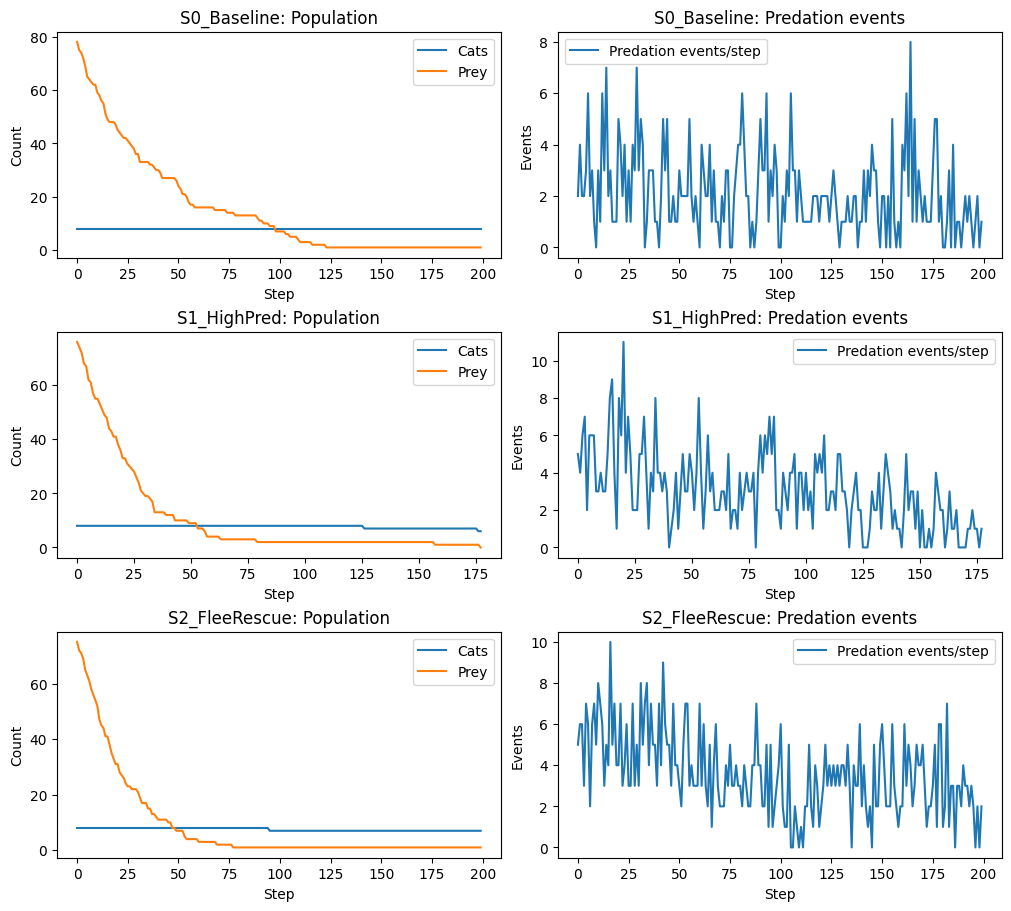

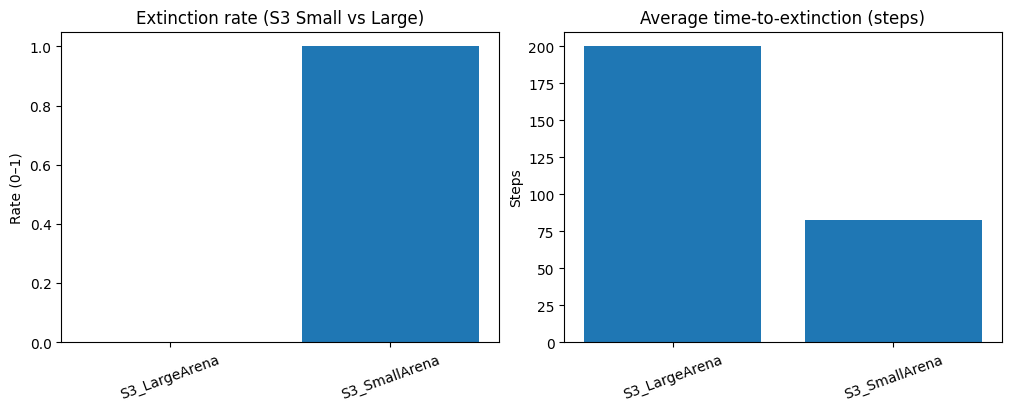

=== S4 Near-threshold summary ===


group,extinction_rate,avg_tte,final_prey_mean,final_cats_mean
S4_coef_0.16,0.40,179,1.0,6.7
S4_coef_0.20,0.70,157,1.2,7.3


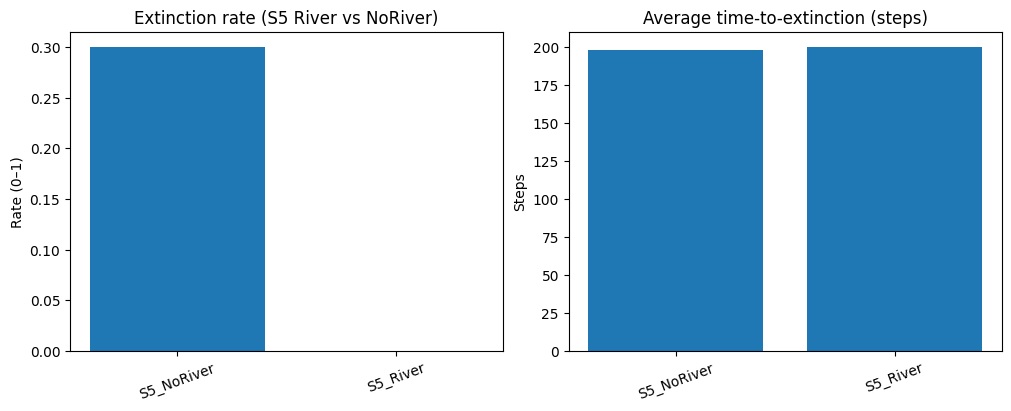

In [30]:
# Scenarios: S0 Baseline, S1 High pred, S2 Flee rescue, S3 Space effect (small/large),
#            S4 Near-threshold (coef 0.16 vs 0.20), S5 River vs NoRiver (spatial refugia & bottlenecks)
# Requires: src/model.py with FeralCatModel + DataCollector reporters "Cats","Prey"


# --------------------------
# 1) Settings
# --------------------------
SEEDS = [4009, 4403, 4012, 5505, 5526, 1003, 1314, 6666, 17, 111]   # run 10 seeds for stability
MAX_STEPS = 200 # max steps per run

SCENARIOS = [
    # S0 — Baseline
    dict(group="S0_Baseline", width=25, height=25, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.10, prey_flee_prob=0.40),

    # S1 — High predation
    dict(group="S1_HighPred", width=25, height=25, n_cats=8, n_prey=80,
         predation_base=0.40, predation_coef=0.20, prey_flee_prob=0.20),

    # S2 — Flee rescue
    dict(group="S2_FleeRescue", width=25, height=25, n_cats=8, n_prey=80,
         predation_base=0.40, predation_coef=0.20, prey_flee_prob=0.80),

    # S3 — Space effect (small vs large)
    dict(group="S3_SmallArena", width=15, height=15, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.10, prey_flee_prob=0.40),
    dict(group="S3_LargeArena", width=40, height=40, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.10, prey_flee_prob=0.40),

    # S4 — Near-threshold (two close coefficients)
    dict(group="S4_coef_0.16",  width=25, height=25, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.16, prey_flee_prob=0.40),
    dict(group=f"S4_coef_0.20",  width=25, height=25, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.20, prey_flee_prob=0.40),

    # S5 — River barrier vs no barrier (spatial refugia & bottlenecks)
    dict(group="S5_River",      width=25, height=25, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.10, prey_flee_prob=0.40, river_exist=True),
    dict(group="S5_NoRiver",    width=25, height=25, n_cats=8,  n_prey=80,
         predation_base=0.20, predation_coef=0.10, prey_flee_prob=0.40, river_exist=False), 
]

# --------------------------
# 2) Single run function
# --------------------------
def run_once(params: dict, seed: int, max_steps: int = MAX_STEPS, **kwargs):
    river_exist = kwargs.get("river_exist", True)
    m = FeralCatModel(
        width=params["width"], height=params["height"],
        n_cats=params["n_cats"], n_prey=params["n_prey"],
        predation_base=params["predation_base"], predation_coef=params["predation_coef"],
        prey_flee_prob=params["prey_flee_prob"], seed=seed,
        vegetation=None, river=None, river_exist=river_exist  # default: your model randomly creates vegetation and river
    )
    steps = 0
    while m.running and steps < max_steps:
        m.step(); steps += 1

    df = m.datacollector.get_model_vars_dataframe().reset_index().rename(columns={"index":"step"})
    df["group"], df["seed"], df["total_steps"] = params["group"], seed, steps

    # metrics
    extinct_mask = (df["Prey"] <= 0)
    extinct = bool(extinct_mask.any())
    tte = int(df.loc[extinct_mask, "step"].min()) if extinct else max_steps
    final_prey = int(df["Prey"].iloc[-1])
    final_cats = int(df["Cats"].iloc[-1])
    pred_total = int(df["predation_events_this_step"].sum()) if "predation_events_this_step" in df.columns else np.nan

    summary = dict(group=params["group"], seed=seed, extinct=extinct, tte=tte,
                   final_prey=final_prey, final_cats=final_cats,
                   pred_events_total=pred_total, steps=steps)
    return summary, df

# --------------------------
# 3) Run all scenarios × seeds
# --------------------------
run_rows, traces = [], []
for sc in SCENARIOS:
    for s in SEEDS:
        res, trace = run_once(sc, seed=s, max_steps=MAX_STEPS)
        run_rows.append({**sc, **res})
        traces.append(trace)

runs_df   = pd.DataFrame(run_rows)
traces_df = pd.concat(traces, ignore_index=True)

# Scenario-level summary
summary = (runs_df.groupby("group", as_index=False)
           .agg(extinction_rate=("extinct","mean"),
                avg_tte=("tte","mean"),
                final_prey_mean=("final_prey","mean"),
                final_cats_mean=("final_cats","mean"),
                pred_events_avg=("pred_events_total","mean"))
           .sort_values(["group"])
          )

print("=== Scenario summary ===")
display(summary)


# --------------------------
# 4) Visualisation
# --------------------------

# Figure 1: S0/S1/S2 — side-by-side time series (Population & Predation Events)
# We plot a representative seed (first in SEEDS). Skip predation events if not recorded.
seed0 = SEEDS[0]
groups_012 = ["S0_Baseline","S1_HighPred","S2_FleeRescue"]
sub = traces_df[(traces_df["seed"] == seed0) & (traces_df["group"].isin(groups_012))]

# Create 3x2 grid: rows = scenarios (S0, S1, S2); cols = [Population, Predation events]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9), sharex=False, constrained_layout=True)
for i, g in enumerate(groups_012):
    d = sub[sub["group"]==g]
    # Left: Population
    ax = axes[i,0]
    ax.plot(d["step"], d["Cats"], label="Cats")
    ax.plot(d["step"], d["Prey"], label="Prey")
    ax.set_title(f"{g}: Population")
    ax.set_xlabel("Step"); ax.set_ylabel("Count"); ax.legend()

    # Right: Predation events (if available)
    ax = axes[i,1]
    if "predation_events_this_step" in d.columns:
        ax.plot(d["step"], d["predation_events_this_step"], label="Predation events/step")
        ax.set_title(f"{g}: Predation events")
        ax.set_xlabel("Step"); ax.set_ylabel("Events"); ax.legend()
    else:
        ax.set_title(f"{g}: Predation events (not recorded)")
        ax.axis("off")

plt.show()

# Figure 2: S3 (Small vs Large) — extinction rate + avg TTE bars
s3_summary = summary[summary["group"].isin(["S3_SmallArena","S3_LargeArena"])].copy()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)

ax1.bar(s3_summary["group"], s3_summary["extinction_rate"])
ax1.set_title("Extinction rate (S3 Small vs Large)"); ax1.set_ylabel("Rate (0–1)")
ax1.tick_params(axis='x', rotation=20)

ax2.bar(s3_summary["group"], s3_summary["avg_tte"])
ax2.set_title("Average time-to-extinction (steps)"); ax2.set_ylabel("Steps")
ax2.tick_params(axis='x', rotation=20)

plt.show()

# Figure 3: S4 Near-threshold — small summary table
s4_table = summary[summary["group"].isin(["S4_coef_0.16","S4_coef_0.20"])][
    ["group","extinction_rate","avg_tte","final_prey_mean","final_cats_mean"]
].reset_index(drop=True)

print("=== S4 Near-threshold summary ===")
fmt = {
    "extinction_rate": lambda v: f"{v:.2f}",
    "avg_tte":         lambda v: f"{v:.0f}",
    "final_prey_mean": lambda v: f"{v:.1f}",
    "final_cats_mean": lambda v: f"{v:.1f}",
}
display(HTML(s4_table.to_html(index=False, formatters=fmt)))

# Figure 4: S5 River vs NoRiver — extinction rate + avg TTE bars
s5_summary = summary[summary["group"].isin(["S5_River","S5_NoRiver"])].copy()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)    
ax1.bar(s5_summary["group"], s5_summary["extinction_rate"])
ax1.set_title("Extinction rate (S5 River vs NoRiver)"); ax1.set_ylabel("Rate (0–1)")
ax1.tick_params(axis='x', rotation=20)
ax2.bar(s5_summary["group"], s5_summary["avg_tte"])
ax2.set_title("Average time-to-extinction (steps)"); ax2.set_ylabel("Steps")
ax2.tick_params(axis='x', rotation=20)
plt.show()

## 5. Results Interpretation


This part analyzes the results from the experiment part.

S0 – Baseline.
With moderate predation the system tends to drift down slowly: prey often decline to very low levels near the end of 200 steps (extinction rate ≈ 0.30, TTE ≈ 190). Cats stay relatively stable around a small band. Predation events are mid-range.

S1 – High predation.
Stronger pressure (more cats + higher base/coef) produces a clearer boom–bust: prey fall faster, cats peak briefly and then flatten. Extinction rate rises to 0.60 and average TTE shortens (≈ 181), with more frequent predation events than S0.

S2 – Flee rescue.
Raising prey_flee_prob does help: the extinction rate drops versus S1 (0.50 vs 0.60) and survivors end with slightly more prey on average. That said, collapses can still happen and TTE isn’t guaranteed to increase—flight spreads risk but can’t fully offset high per-encounter success.

S3 – Space (encounter rate).
Changing only arena size isolates the effect of encounters. In the small grid (15×15), prey go extinct in every run (1.00, TTE ≈ 83). In the large grid (40×40), we see 0 extinctions within 200 steps and much higher final prey, while cats drift lower (fewer encounters → less energy intake). This neatly shows “contact rate” as a dominant driver.

S4 – Near-threshold sensitivity.
A tiny tweak to predation_coef flips outcomes: from 0.16 to 0.20, the extinction rate jumps 0.40 → 0.70 and TTE shortens ≈179 → ≈157. This is a nice tipping-point story—small changes in hunting success can shift the system from “often coexist” to “often collapse”.

S5 – River barrier vs no barrier.
With a river (river_exist=True), we recorded 0 extinctions in 200 steps versus 0.30 without the river, and final prey numbers are a bit higher. The barrier likely creates refugia and funnels encounters to narrow crossings; the total number of predation events is similar, but their locations are more constrained, which helps prey persist.

Summary
Across all scenarios, two levers matter most: how often agents meet (space, barriers) and what happens when they meet (predation base/coef, flee behaviour). Increasing flight buys time and lowers risk but can’t fully beat strong predation; adding spatial structure (bigger habitat or a barrier) is consistently protective. Results vary a bit across seeds, but the patterns above are stable enough to support these conclusions.

## 6. Limitations

Since the model simulates several scenarios decently, there are still some limitations:

**Simple rules**. Predator–prey interactions are simplified (e.g., linear predation rule, simple flee trigger, simple energy use). Real systems likely need non-linear or context-dependent rules, not so close to the real situation.

**Random vegetation**. Most simulations use a fresh random vegetation map, which adds noise. A fixed map per scenario would make comparisons cleaner.

**Space is stylised**. The grid and the river mask are idealised; real landscapes have varied permeability, multiple barriers, and edges.

**Metrics are narrow**. We mainly tracked population, predation and extinction/TTE. We did not analyse spatial clustering, home ranges, or variability bands in depth.

What we’d improve next: calibrate with real data, add seasonality and heterogeneity, fix vegetation maps per scenario, increase seeds and run length, and measure spatial patterns (e.g., clustering) alongside population counts.

## 7. Conclusion

This project showed that two levers dominate our system: how often cats and prey meet (space, barriers) and what happens when they meet (predation success, fleeing). 

Under baseline settings we saw mild oscillations that often drifted to very low prey numbers; pushing predation up (S1) produced faster collapses, while raising the flee probability (S2) helped but did not fully prevent declines. Changing only the arena size (S3) made the biggest difference: the small grid led to certain extinction within 200 steps, whereas the large grid avoided it entirely in our runs. A river barrier (S5) acted like a refuge by concentrating encounters at crossings and protecting prey elsewhere. Finally, the near-threshold test (S4) showed that small tweaks to predation success can flip the regime from coexistence to frequent extinction—a clear tipping-point message. 

Overall, if the goal is persistence, the most effective strategies are to reduce encounter rates (more space, obstacles/refugia) or lower per-encounter success (behavioural or habitat protections).